# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

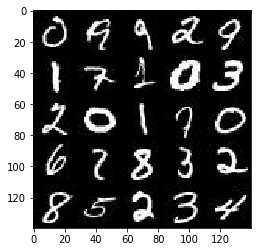

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

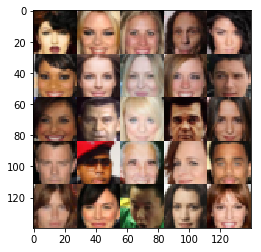

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discr_kern_init():
    return None
    #return tf.random_normal_initializer(stddev=0.02)

In [51]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example

    alpha = 0.2
    kernel_size = 4
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same', kernel_initializer=discr_kern_init())
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.get_shape())
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, kernel_size, strides=2, padding='same', kernel_initializer=discr_kern_init())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.get_shape())
        # 7x7x128
                
        x3 = tf.layers.conv2d(relu2, 256, kernel_size, strides=2, padding='same', kernel_initializer=discr_kern_init())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.get_shape())
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        #print(flat.get_shape())
        logits = tf.layers.dense(flat, 1)
        #print(logits.get_shape())
        out = tf.sigmoid(logits)
        #print(out.get_shape())
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [61]:
def gen_kern_init():
    return None
    #return tf.random_normal_initializer(stddev=0.02)

In [62]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example
    
    alpha = 0.2
    reuse = not is_train
    kernel_size = 4
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        #print(x1.get_shape())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size, strides=1, padding='valid', kernel_initializer=gen_kern_init())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size, strides=2, padding='same', kernel_initializer=gen_kern_init())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 14x14x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=2, padding='same', kernel_initializer=gen_kern_init())
        #print(logits.get_shape())
        # 28x28x5 now
                
        out = tf.tanh(logits)
        #print(out.get_shape())
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # derived from udacity/deep-learning dcgan-svhn/DCGAN.ipynb example
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [66]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    n_images = 16
    print_every = 100
    show_every = 200
    
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
                               
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} (step: {})...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 0.8982
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 1.8564... Generator Loss: 0.2723
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.4454
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 0.9356
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 0.9720... Generator Loss: 0.8512


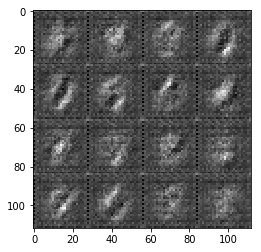

Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 0.6539
Epoch 1/2... Discriminator Loss: 1.0879... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.4536
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 0.8251
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 0.8991


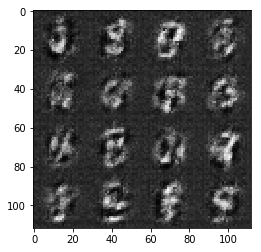

Epoch 1/2... Discriminator Loss: 0.6616... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 0.5711... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 0.4652... Generator Loss: 1.4181
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.4901
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 1.4133
Epoch 1/2... Discriminator Loss: 0.4209... Generator Loss: 2.1531
Epoch 1/2... Discriminator Loss: 0.3257... Generator Loss: 1.9969
Epoch 1/2... Discriminator Loss: 0.3220... Generator Loss: 2.0682
Epoch 1/2... Discriminator Loss: 1.9146... Generator Loss: 5.1156
Epoch 1/2... Discriminator Loss: 0.2957... Generator Loss: 2.3383


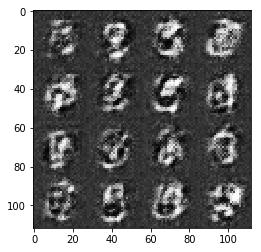

Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 4.4658
Epoch 1/2... Discriminator Loss: 0.2404... Generator Loss: 2.5475
Epoch 1/2... Discriminator Loss: 0.2379... Generator Loss: 2.1726
Epoch 1/2... Discriminator Loss: 0.2725... Generator Loss: 2.1987
Epoch 1/2... Discriminator Loss: 0.5056... Generator Loss: 3.2205
Epoch 1/2... Discriminator Loss: 0.4442... Generator Loss: 3.7686
Epoch 1/2... Discriminator Loss: 0.2899... Generator Loss: 1.8115
Epoch 1/2... Discriminator Loss: 0.2711... Generator Loss: 2.5508
Epoch 1/2... Discriminator Loss: 0.3036... Generator Loss: 3.2588
Epoch 1/2... Discriminator Loss: 0.1765... Generator Loss: 3.0584


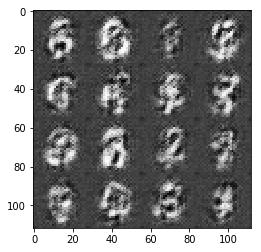

Epoch 1/2... Discriminator Loss: 0.3127... Generator Loss: 1.7052
Epoch 1/2... Discriminator Loss: 0.4726... Generator Loss: 1.2581
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 1.5353
Epoch 1/2... Discriminator Loss: 0.2899... Generator Loss: 1.9481
Epoch 1/2... Discriminator Loss: 0.2921... Generator Loss: 1.8454
Epoch 2/2... Discriminator Loss: 0.2219... Generator Loss: 2.1310
Epoch 2/2... Discriminator Loss: 0.2270... Generator Loss: 2.1987
Epoch 2/2... Discriminator Loss: 0.2727... Generator Loss: 1.9673
Epoch 2/2... Discriminator Loss: 0.2624... Generator Loss: 1.9083


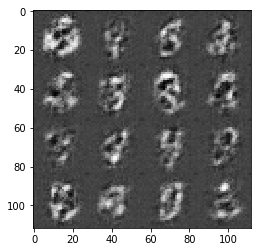

Epoch 2/2... Discriminator Loss: 0.4371... Generator Loss: 1.2784
Epoch 2/2... Discriminator Loss: 0.2213... Generator Loss: 2.3272
Epoch 2/2... Discriminator Loss: 0.2353... Generator Loss: 1.9856
Epoch 2/2... Discriminator Loss: 0.1982... Generator Loss: 2.2484
Epoch 2/2... Discriminator Loss: 0.2706... Generator Loss: 1.8076
Epoch 2/2... Discriminator Loss: 0.7317... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 0.3262... Generator Loss: 1.9529
Epoch 2/2... Discriminator Loss: 0.2057... Generator Loss: 2.2898
Epoch 2/2... Discriminator Loss: 0.1857... Generator Loss: 2.4776
Epoch 2/2... Discriminator Loss: 0.1582... Generator Loss: 2.5084


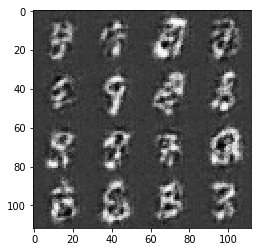

Epoch 2/2... Discriminator Loss: 0.1823... Generator Loss: 2.4172
Epoch 2/2... Discriminator Loss: 0.1614... Generator Loss: 2.5167
Epoch 2/2... Discriminator Loss: 0.2662... Generator Loss: 1.7843
Epoch 2/2... Discriminator Loss: 0.1664... Generator Loss: 2.5057
Epoch 2/2... Discriminator Loss: 0.1732... Generator Loss: 2.3400
Epoch 2/2... Discriminator Loss: 0.1820... Generator Loss: 2.3785
Epoch 2/2... Discriminator Loss: 0.1691... Generator Loss: 2.5429
Epoch 2/2... Discriminator Loss: 0.1741... Generator Loss: 3.2066
Epoch 2/2... Discriminator Loss: 0.1432... Generator Loss: 2.6980
Epoch 2/2... Discriminator Loss: 0.1182... Generator Loss: 3.1932


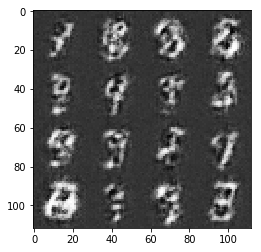

Epoch 2/2... Discriminator Loss: 0.1354... Generator Loss: 2.7204
Epoch 2/2... Discriminator Loss: 0.1461... Generator Loss: 2.6116
Epoch 2/2... Discriminator Loss: 0.1429... Generator Loss: 2.6305
Epoch 2/2... Discriminator Loss: 0.1271... Generator Loss: 2.9674
Epoch 2/2... Discriminator Loss: 0.1251... Generator Loss: 2.7899
Epoch 2/2... Discriminator Loss: 0.1657... Generator Loss: 2.3298
Epoch 2/2... Discriminator Loss: 0.1324... Generator Loss: 2.6430
Epoch 2/2... Discriminator Loss: 0.1378... Generator Loss: 3.0070
Epoch 2/2... Discriminator Loss: 0.1199... Generator Loss: 2.9086
Epoch 2/2... Discriminator Loss: 0.1118... Generator Loss: 2.8109


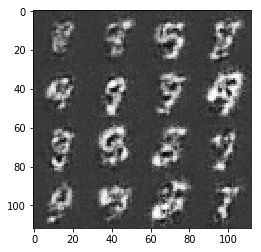

Epoch 2/2... Discriminator Loss: 0.1430... Generator Loss: 2.5576
Epoch 2/2... Discriminator Loss: 0.1396... Generator Loss: 2.6560
Epoch 2/2... Discriminator Loss: 0.1109... Generator Loss: 2.8359
Epoch 2/2... Discriminator Loss: 0.1082... Generator Loss: 2.7440
Epoch 2/2... Discriminator Loss: 0.1096... Generator Loss: 2.8223
Epoch 2/2... Discriminator Loss: 0.1027... Generator Loss: 2.8805
Epoch 2/2... Discriminator Loss: 0.2134... Generator Loss: 1.9499
Epoch 2/2... Discriminator Loss: 1.5348... Generator Loss: 0.3761
Epoch 2/2... Discriminator Loss: 0.2011... Generator Loss: 2.2797
Epoch 2/2... Discriminator Loss: 0.1412... Generator Loss: 2.6282


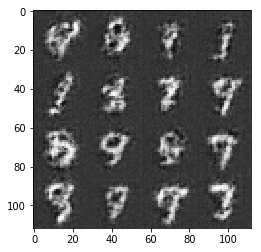

Epoch 2/2... Discriminator Loss: 0.1609... Generator Loss: 2.5058
Epoch 2/2... Discriminator Loss: 0.1786... Generator Loss: 2.3543
Epoch 2/2... Discriminator Loss: 0.1220... Generator Loss: 2.6858


In [64]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10 (step: 100)... Discriminator Loss: 0.0232... Generator Loss: 9.6950
Epoch 1/10 (step: 200)... Discriminator Loss: 1.3406... Generator Loss: 0.4518


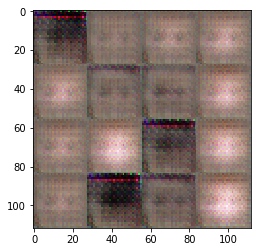

Epoch 1/10 (step: 300)... Discriminator Loss: 1.2129... Generator Loss: 3.5406
Epoch 1/10 (step: 400)... Discriminator Loss: 0.8209... Generator Loss: 0.8813


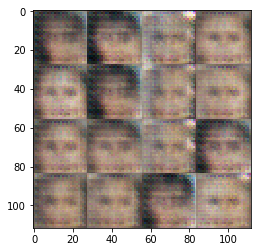

Epoch 1/10 (step: 500)... Discriminator Loss: 1.0683... Generator Loss: 0.9064
Epoch 1/10 (step: 600)... Discriminator Loss: 0.1113... Generator Loss: 3.4485


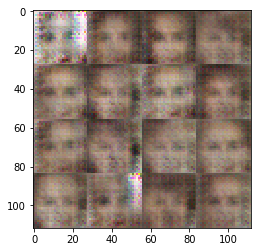

Epoch 1/10 (step: 700)... Discriminator Loss: 0.0900... Generator Loss: 4.3614
Epoch 1/10 (step: 800)... Discriminator Loss: 0.9991... Generator Loss: 1.2180


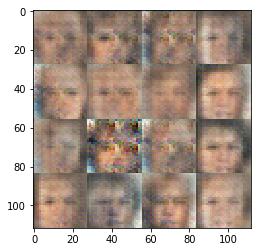

Epoch 1/10 (step: 900)... Discriminator Loss: 0.6441... Generator Loss: 1.3091
Epoch 1/10 (step: 1000)... Discriminator Loss: 1.1175... Generator Loss: 1.8390


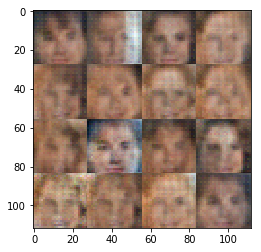

Epoch 1/10 (step: 1100)... Discriminator Loss: 1.4586... Generator Loss: 0.3358
Epoch 1/10 (step: 1200)... Discriminator Loss: 0.8120... Generator Loss: 1.6941


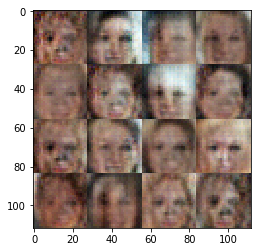

Epoch 1/10 (step: 1300)... Discriminator Loss: 0.6135... Generator Loss: 2.3589
Epoch 1/10 (step: 1400)... Discriminator Loss: 0.5169... Generator Loss: 1.3057


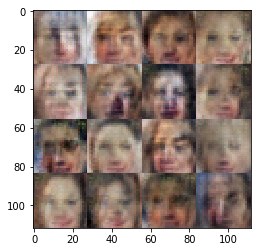

Epoch 1/10 (step: 1500)... Discriminator Loss: 0.9939... Generator Loss: 0.7666
Epoch 2/10 (step: 1600)... Discriminator Loss: 1.3089... Generator Loss: 0.4596


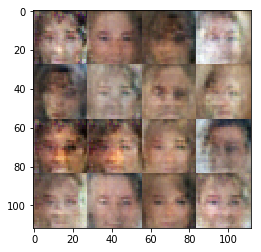

Epoch 2/10 (step: 1700)... Discriminator Loss: 0.7740... Generator Loss: 1.1110
Epoch 2/10 (step: 1800)... Discriminator Loss: 1.1866... Generator Loss: 0.9687


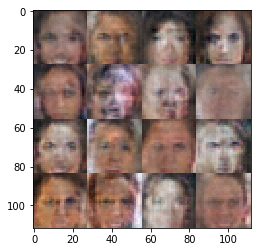

Epoch 2/10 (step: 1900)... Discriminator Loss: 0.6065... Generator Loss: 1.2861
Epoch 2/10 (step: 2000)... Discriminator Loss: 0.9192... Generator Loss: 1.0204


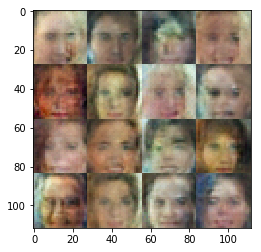

Epoch 2/10 (step: 2100)... Discriminator Loss: 0.5063... Generator Loss: 1.7815
Epoch 2/10 (step: 2200)... Discriminator Loss: 0.9914... Generator Loss: 0.9524


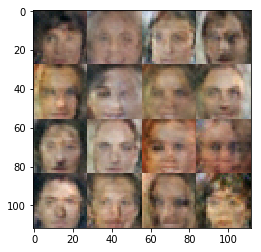

Epoch 2/10 (step: 2300)... Discriminator Loss: 0.9874... Generator Loss: 1.4734
Epoch 2/10 (step: 2400)... Discriminator Loss: 0.9092... Generator Loss: 1.0909


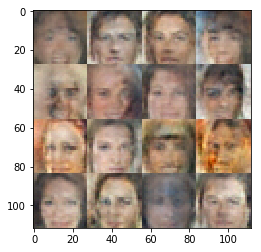

Epoch 2/10 (step: 2500)... Discriminator Loss: 1.0863... Generator Loss: 0.5835
Epoch 2/10 (step: 2600)... Discriminator Loss: 0.9093... Generator Loss: 1.2234


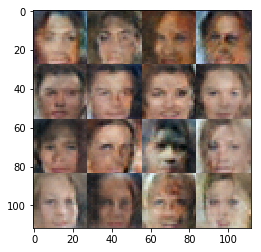

Epoch 2/10 (step: 2700)... Discriminator Loss: 1.0156... Generator Loss: 0.9384
Epoch 2/10 (step: 2800)... Discriminator Loss: 1.0858... Generator Loss: 0.8168


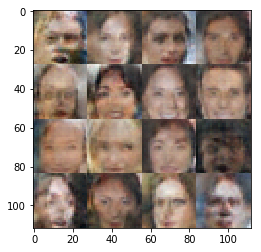

Epoch 2/10 (step: 2900)... Discriminator Loss: 0.9820... Generator Loss: 1.0201
Epoch 2/10 (step: 3000)... Discriminator Loss: 0.9070... Generator Loss: 0.8082


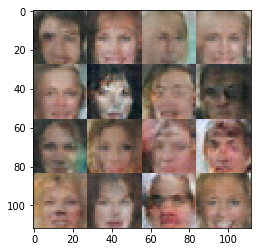

Epoch 2/10 (step: 3100)... Discriminator Loss: 0.8188... Generator Loss: 1.1856
Epoch 3/10 (step: 3200)... Discriminator Loss: 1.6625... Generator Loss: 0.2651


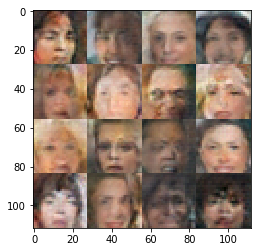

Epoch 3/10 (step: 3300)... Discriminator Loss: 1.0913... Generator Loss: 0.6612
Epoch 3/10 (step: 3400)... Discriminator Loss: 1.2108... Generator Loss: 0.8085


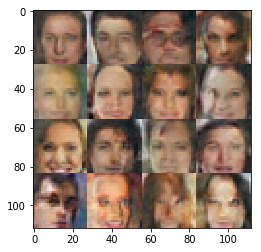

Epoch 3/10 (step: 3500)... Discriminator Loss: 1.2376... Generator Loss: 0.4978
Epoch 3/10 (step: 3600)... Discriminator Loss: 1.0037... Generator Loss: 0.8556


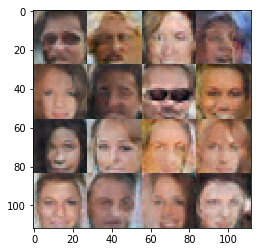

Epoch 3/10 (step: 3700)... Discriminator Loss: 1.1011... Generator Loss: 0.5800
Epoch 3/10 (step: 3800)... Discriminator Loss: 1.1988... Generator Loss: 0.4541


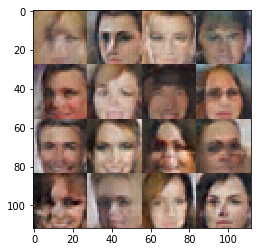

Epoch 3/10 (step: 3900)... Discriminator Loss: 1.1498... Generator Loss: 0.7021
Epoch 3/10 (step: 4000)... Discriminator Loss: 1.1790... Generator Loss: 0.5898


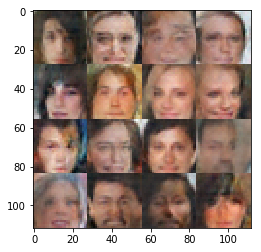

Epoch 3/10 (step: 4100)... Discriminator Loss: 1.4043... Generator Loss: 1.9336
Epoch 3/10 (step: 4200)... Discriminator Loss: 1.1171... Generator Loss: 0.6665


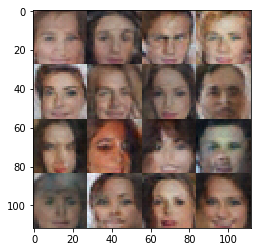

Epoch 3/10 (step: 4300)... Discriminator Loss: 1.1687... Generator Loss: 0.5990
Epoch 3/10 (step: 4400)... Discriminator Loss: 1.0193... Generator Loss: 1.2289


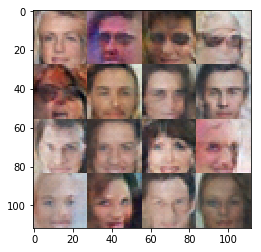

Epoch 3/10 (step: 4500)... Discriminator Loss: 1.1076... Generator Loss: 0.5937
Epoch 3/10 (step: 4600)... Discriminator Loss: 1.4961... Generator Loss: 0.3350


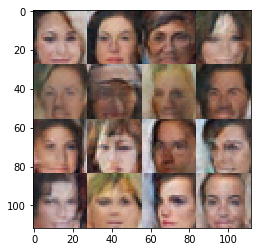

Epoch 3/10 (step: 4700)... Discriminator Loss: 0.9533... Generator Loss: 1.1127


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.